In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import argparse
import torch

if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

print(torch.cuda.get_device_name(0))


Using GPU
NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
week_1 = "../data/traffic/OpenStack/CIDDS-001-internal-week1.csv"
week_2 = "../data/traffic/OpenStack/CIDDS-001-internal-week2.csv"

In [3]:
week_1 = pd.read_csv(week_1)
week_2 = pd.read_csv(week_2)

C:\Users\cupca\AppData\Local\Temp\ipykernel_26200\734835057.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  week_1 = pd.read_csv(week_1)
C:\Users\cupca\AppData\Local\Temp\ipykernel_26200\734835057.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  week_2 = pd.read_csv(week_2)


In [4]:
# Rename columns
week_1 = week_1.rename(str.lower, axis='columns')
week_1 = week_1.rename(str.strip, axis='columns')
week_1.rename(columns={
            'date first seen': 'date_first_seen', 
            'src ip addr': 'src_ip_addr',
            'src pt': 'src_pt',
            'dst ip addr': 'dst_ip_addr',
            'dst pt': 'dst_pt',
            'attacktype': 'attack_type',
            'attackid': 'attack_id',
            'attackdescription': 'attack_description',
            'class': 'label'
        }, inplace=True)

week_2 = week_2.rename(str.lower, axis='columns')
week_2 = week_2.rename(str.strip, axis='columns')
week_2.rename(columns={
            'date first seen': 'date_first_seen', 
            'src ip addr': 'src_ip_addr',
            'src pt': 'src_pt',
            'dst ip addr': 'dst_ip_addr',
            'dst pt': 'dst_pt',
            'attacktype': 'attack_type',
            'attackid': 'attack_id',
            'attackdescription': 'attack_description',
            'class': 'label'
        }, inplace=True)

In [5]:
week_1.shape, week_2.shape

((8451520, 16), (10310733, 16))

In [6]:
def remove_million(val):
    """
    Removes the 'M' or 'K' suffix from a string and converts it to a numeric value.

    Args:
        val (str or int): The value to be processed. If it is a string, it should contain a suffix 'M' or 'K'.

    Returns:
        str or int: The processed value. If the input is a string, it is converted to an integer.

    Example:
        >>> remove_million('1.5 M')
        1500000
        >>> remove_million('2.3 K')
        2300
        >>> remove_million(100)
        100
    """
    if type(val) is str:                
        val = val.strip()
        if ' M' in val:                    
            val = val.replace('.', '')
            val = val.replace(' M', '00000')  
        if ' K' in val:                    
            val = val.replace('.', '')
            val = val.replace(' K', '000')                
        return val
    elif type(val) is int:
        return val

In [8]:
def hex_to_tcp_flags(hex_value):
    """
    Converts a hexadecimal value to TCP flags.

    Args:
    hex_value (str): The hexadecimal value to convert.

    Returns:
    str: The TCP flags represented as a string.

    Example:
    >>> hex_to_tcp_flags('0x52')
    '.E.A..S.'
    """
    binary_value = bin(int(hex_value, 16))[2:].zfill(8)
    flags = ['C', 'E', 'U', 'A', 'P', 'R', 'S', 'F']
    tcp_flags = ''.join([flags[i] if bit == '1' else '.' for i, bit in enumerate(binary_value)])
    return tcp_flags

In [9]:
data_dfs = [week_1, week_2]
for df in data_dfs:
        # Remove million suffix from 'bytes' column
    df['bytes'] = df['bytes'].apply(remove_million)
    df['bytes'] = pd.to_numeric(df['bytes'], errors='raise', downcast='float')
    
    # Remove NA and INF values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print("N/A rows after preproc", df.isna().any(axis=1).sum())
    df.dropna(inplace=True)
    
    # Convert hexadecimal TCP flags to custom format
    df["flags"] = df["flags"].apply(lambda x:hex_to_tcp_flags(x) if '0x' in x else x)
    df['flags'] = df['flags'].apply(lambda x: '.' * (8 - len(str(x))) + str(x))

    # One-hot encode TCP flags
    df['flags'] = df['flags'].str.strip()
    data_df = df['flags'].apply(func=lambda flag_str: [0 if c == '.' else 1 for c in flag_str]).to_list()
    columns_df = ['tcp_con','tcp_ech','tcp_urg', 'tcp_ack', 'tcp_psh', 'tcp_rst', 'tcp_syn', 'tcp_fin']
    ohe_flag_data = pd.DataFrame(data=data_df,columns=columns_df,dtype=int)
    flags_idx = df.columns.get_loc('flags')
    for i, c in enumerate(ohe_flag_data.columns):
        df.insert(loc=flags_idx+i, column=c, value=ohe_flag_data[c])

    # Preprocess other columns
    df["proto"] = df["proto"].str.strip()
    df['attack_type'] = df['attack_type'].replace({'---': 'benign'})
    df['attack_id'] = df['attack_id'].replace({'---': 0})
    df['attack_id'] = df['attack_id'].astype(np.int32)
    df['tos'] = df['tos'].astype(np.int32)
    df = df[~df['proto'].isin(['IGMP', 'GRE'])]
    df.reset_index(drop=True, inplace=True)

N/A rows after preproc 0
N/A rows after preproc 0


In [9]:
week_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8451520 entries, 0 to 8451519
Data columns (total 24 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date_first_seen     object 
 1   duration            float64
 2   proto               object 
 3   src_ip_addr         object 
 4   src_pt              int64  
 5   dst_ip_addr         object 
 6   dst_pt              float64
 7   packets             int64  
 8   bytes               float32
 9   flows               int64  
 10  tcp_con             int32  
 11  tcp_ech             int32  
 12  tcp_urg             int32  
 13  tcp_ack             int32  
 14  tcp_psh             int32  
 15  tcp_rst             int32  
 16  tcp_syn             int32  
 17  tcp_fin             int32  
 18  flags               object 
 19  tos                 int32  
 20  label               object 
 21  attack_type         object 
 22  attack_id           int32  
 23  attack_description  object 
dtypes: float32(1), float64(2

In [10]:
week_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10310733 entries, 0 to 10310732
Data columns (total 24 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date_first_seen     object 
 1   duration            float64
 2   proto               object 
 3   src_ip_addr         object 
 4   src_pt              int64  
 5   dst_ip_addr         object 
 6   dst_pt              float64
 7   packets             int64  
 8   bytes               float32
 9   flows               int64  
 10  tcp_con             int32  
 11  tcp_ech             int32  
 12  tcp_urg             int32  
 13  tcp_ack             int32  
 14  tcp_psh             int32  
 15  tcp_rst             int32  
 16  tcp_syn             int32  
 17  tcp_fin             int32  
 18  flags               object 
 19  tos                 int32  
 20  label               object 
 21  attack_type         object 
 22  attack_id           int32  
 23  attack_description  object 
dtypes: float32(1), float64

In [10]:
for df in data_dfs:
    df.drop(columns=['src_ip_addr', 'dst_ip_addr', 'date_first_seen', 'attack_description', 'attack_id', 'flows', 'flags'], inplace=True)

In [12]:
week_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8451520 entries, 0 to 8451519
Data columns (total 17 columns):
 #   Column       Dtype  
---  ------       -----  
 0   duration     float64
 1   proto        object 
 2   src_pt       int64  
 3   dst_pt       float64
 4   packets      int64  
 5   bytes        float32
 6   tcp_con      int32  
 7   tcp_ech      int32  
 8   tcp_urg      int32  
 9   tcp_ack      int32  
 10  tcp_psh      int32  
 11  tcp_rst      int32  
 12  tcp_syn      int32  
 13  tcp_fin      int32  
 14  tos          int32  
 15  label        object 
 16  attack_type  object 
dtypes: float32(1), float64(2), int32(9), int64(2), object(3)
memory usage: 773.8+ MB


In [11]:
# set float format
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [12]:
for df in data_dfs:
    #normalize values
    df["src_pt"] = df["src_pt"]/df["src_pt"].max()
    df["dst_pt"] = df["dst_pt"]/df["dst_pt"].max()
    columns_df = ['duration', 'bytes', 'packets']
    for c in columns_df:
        if c == "duration":
            df[c] = np.log(df[c]+1)
        else:
            df[c] = np.log(df[c])
        df[c] = (df[c]-df[c].min())/(df[c].max()-df[c].min())

In [13]:
for df in data_dfs:
    # remove duplicated rows
    dupli = df.duplicated().sum()
    if dupli > 0:
        print(dupli, "fully duplicate rows")
        df.drop_duplicates(inplace=True)
        df.reset_index(drop=True, inplace=True)

4037720 fully duplicate rows
5078130 fully duplicate rows


In [16]:
week_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4413800 entries, 0 to 4413799
Data columns (total 17 columns):
 #   Column       Dtype  
---  ------       -----  
 0   duration     float64
 1   proto        object 
 2   src_pt       float64
 3   dst_pt       float64
 4   packets      float64
 5   bytes        float64
 6   tcp_con      int32  
 7   tcp_ech      int32  
 8   tcp_urg      int32  
 9   tcp_ack      int32  
 10  tcp_psh      int32  
 11  tcp_rst      int32  
 12  tcp_syn      int32  
 13  tcp_fin      int32  
 14  tos          int32  
 15  label        object 
 16  attack_type  object 
dtypes: float64(5), int32(9), object(3)
memory usage: 420.9+ MB


In [14]:
week_1.shape, week_2.shape

((4413800, 17), (5232603, 17))

In [15]:
test_1 = week_1.sample(frac=0.7, random_state=42)
rest_1 = week_1.drop(test_1.index)
print(test_1.attack_type.value_counts()), print(rest_1.attack_type.value_counts())

attack_type
benign        2671341
dos            377956
portScan        39278
bruteForce        891
pingScan          194
Name: count, dtype: int64
attack_type
benign        1144475
dos            162518
portScan        16672
bruteForce        390
pingScan           85
Name: count, dtype: int64


(None, None)

In [16]:
test_2 = week_2.sample(frac=0.7, random_state=42)
rest_2 = week_2.drop(test_2.index)
print(test_2.attack_type.value_counts(), rest_2.attack_type.value_counts())

attack_type
benign        3256454
dos            388525
portScan        16259
bruteForce       1332
pingScan          252
Name: count, dtype: int64 attack_type
benign        1395855
dos            166233
portScan         7022
bruteForce        568
pingScan          103
Name: count, dtype: int64


In [26]:
test_1.shape, rest_1.shape, test_2.shape, rest_2.shape

((3089660, 17), (1324140, 17), (3662822, 17), (1569781, 17))

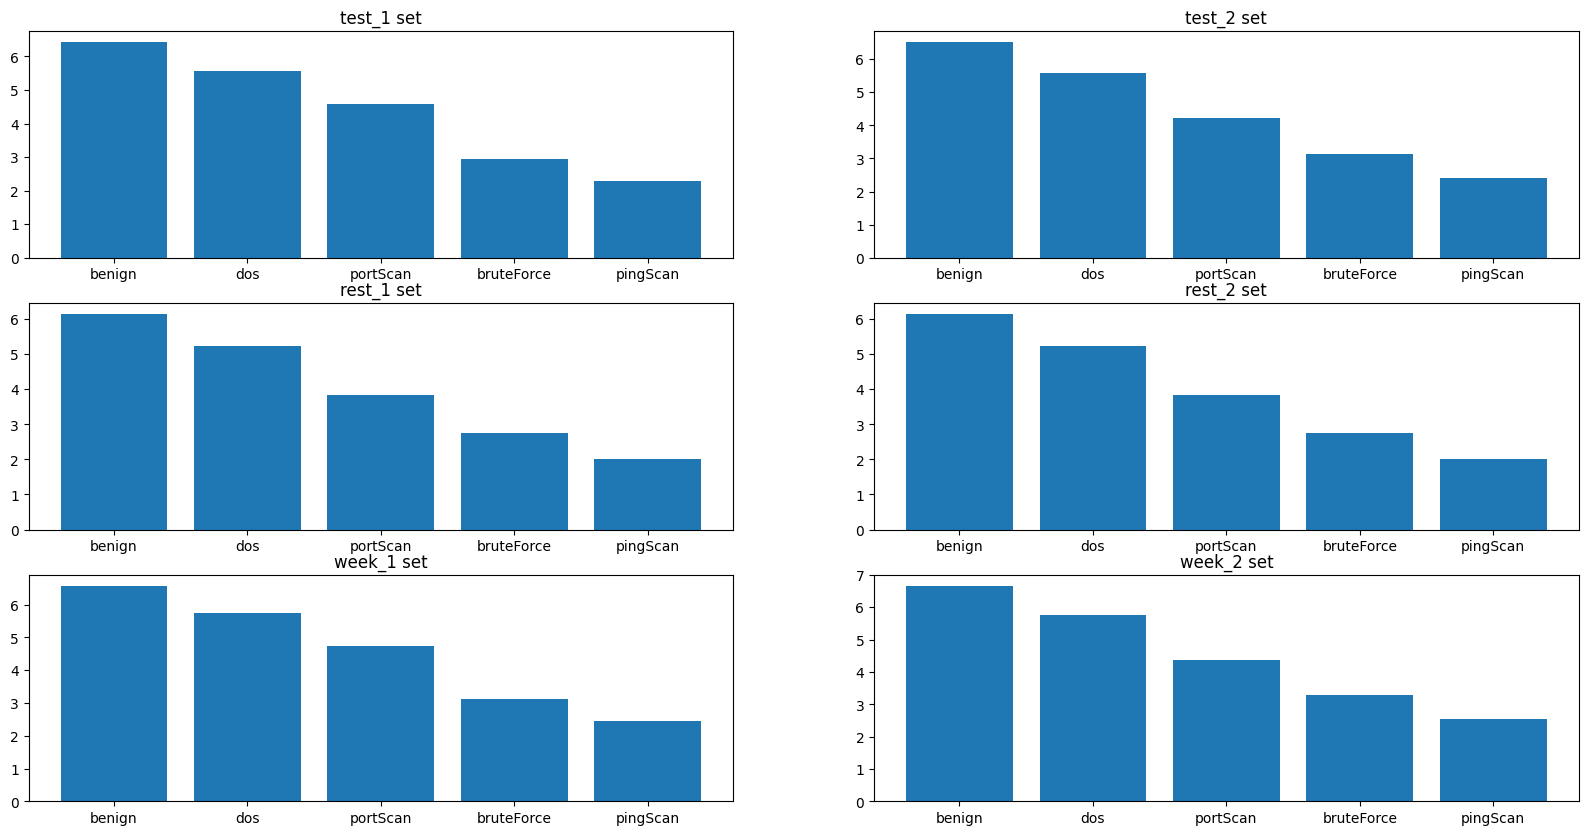

<Figure size 1000x600 with 0 Axes>

In [17]:
#plot the distribution of attack types
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
plt.figure(figsize=(10, 6))
axes[0, 0].bar(test_1.attack_type.value_counts().index, np.log10(test_1.attack_type.value_counts().values))
axes[0, 0].set_title("test_1 set")
axes[0, 1].bar(test_2.attack_type.value_counts().index, np.log10(test_2.attack_type.value_counts().values))
axes[0, 1].set_title("test_2 set")
axes[1, 0].bar(rest_1.attack_type.value_counts().index, np.log10(rest_2.attack_type.value_counts().values))
axes[1, 0].set_title("rest_1 set")
axes[1, 1].bar(rest_2.attack_type.value_counts().index, np.log10(rest_2.attack_type.value_counts().values))
axes[1, 1].set_title("rest_2 set")
axes[2, 0].bar(week_1.attack_type.value_counts().index, np.log10(week_1.attack_type.value_counts().values))
axes[2, 0].set_title("week_1 set")
axes[2, 1].bar(week_2.attack_type.value_counts().index, np.log10(week_2.attack_type.value_counts().values))
axes[2, 1].set_title("week_2 set")
plt.show()

In [22]:
week_1.reset_index(drop=True, inplace=True)
week_2.reset_index(drop=True, inplace=True)

In [18]:
data = pd.concat([week_1, week_2])
data.reset_index(drop=True, inplace=True)

In [19]:
hpo_data = data.sample(frac=0.15, random_state=42)

In [20]:
hpo_data.attack_type.value_counts()*100/hpo_data.attack_type.count()

attack_type
benign       87.78142
dos          11.35843
portScan      0.82110
bruteForce    0.03110
pingScan      0.00795
Name: count, dtype: float64

In [21]:
data.drop(hpo_data.index, inplace=True)

In [22]:
len(hpo_data.index)

1446960

In [23]:
hpo_data.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)

In [26]:
train_data = data.sample(frac=0.35, random_state=42)

In [35]:
test_data = data.drop(train_data.index).sample(frac=0.20, random_state=42)

In [44]:
hpo_data.to_csv("../thesisgan/input/hpo_data.csv", index=False)
train_data.to_csv("../thesisgan/input/train_data.csv", index=False)
test_data.to_csv("../thesisgan/input/test_data.csv", index=False)